In [1]:
import numpy as np
import xarray as xr
import json
import os
import socket
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import xmitgcm as xm

from utils_mitgcm import open_mitgcm_ds_from_config

import eddytools as et

In [2]:
model = 'geneva_200m'

In [3]:
str_start_time = "2023-07-01T12:00:00.000000000"
str_end_time = "2023-07-01T22:00:00.000000000"

outputpath = "./99-Outputs/nencioli/"

# Open MITgcm results

In [4]:
mitgcm_config, ds_to_plot = open_mitgcm_ds_from_config('../config.json', model)

# Preprocess MITgcm inputs

In [5]:
grid_resolution_in_meter = ds_to_plot['XC'].values[1] - ds_to_plot['XC'].values[0]

In [6]:
data_aligned = et.detection_nencioli.preprocess_inputs(str_start_time, str_end_time, ds_to_plot, depth_index=0)

# Detecting eddies at a specific timestep

In [13]:
t_index=3
# Specify parameters for eddy detection
det_param = {
    "model": "MITgcm",
    "grid": "cartesian",
    "hemi": "north",
    "start_time": str_start_time,  # time range start
    "end_time": str_end_time,  # time range end
    "calendar": "standard",  # calendar, must be either 360_day or standard
    "lon1": data_aligned.lon.values.min(),  # minimum longitude of detection region
    "lon2": data_aligned.lon.values.max(),  # maximum longitude
    "lat1": data_aligned.lat.values.min(),  # minimum latitude
    "lat2": data_aligned.lat.values.max(),  # maximum latitude
    "res": grid_resolution_in_meter / 1000,  # resolution of the fields in km
    "min_dep": 1,  # minimum ocean depth where to look for eddies in m
    "no_long": False,  # If True, elongated shapes will not be considered
    "no_two": False,  # If True, eddies with two minima in the OW
    # parameter and a OW > OW_thr in between  will not
    # be considered
    "a": 3, # u/v increase "a" points away from reversal
    "b": 3, # find the velocity minimum within the searching area defined by
            # "b" around the points that satisfy the first two constraints
    "rad": 10, # define the space window in which the algorithm looks for the eddy limits
}


v = data_aligned["VVEL"].isel(time=0).values

i=80
wrk = v[i, :]
# reversal of direction in V
s = np.sign(wrk)
indx = np.where((np.diff(s) != 0) & (~np.isnan(np.diff(s))))[0]

np.where((np.diff(s) != 0) & (~np.isnan(np.diff(s))))

def eddi_exists(eddi, lon_eddie, lat_eddie):
    for e in eddi:
        if eddi[e]["lon"] == lon_eddie and eddi[e]["lat"] == lat_eddie:
            return True
    return False

def detect_UV_core(data, det_param, U, V, SPEED, t, e1f, e2f,
                   regrid_avoided=False):
    if regrid_avoided == True:
        raise ValueError("regrid_avoided cannot be used (yet).")
    u = U.isel(time=t).values
    v = V.isel(time=t).values
    speed = SPEED.isel(time=t).values
    lon, lat = np.meshgrid(data.lon.sel(lon=slice(det_param["lon1"],
                                                  det_param["lon2"])).values,
                           data.lat.sel(lat=slice(det_param["lat1"],
                                                  det_param["lat2"])).values)
    a = det_param["a"]
    b = det_param["b"]
    rad = det_param["rad"]
    borders = np.max([a, b]) + 1
    bounds = np.shape(speed)
    # initialise eddy counter & output dict
    e = 0
    eddi = {}
    
    for i in np.arange(borders, len(v[:, 0])-borders+1):
        wrk = v[i, :]
        # get indexes of all points with reversal of direction in V
        s = np.sign(wrk)
        indx = np.where((np.diff(s) != 0) & (~np.isnan(np.diff(s))))[0]
        indx = indx[((indx > borders) & (indx < (len(wrk) - borders)))]
        # for each of those points, check next criterias
        for ii in np.arange(0, len(indx)):
            # check if v increase "a" points away from reversal
            # anticyclonic
            if wrk[indx[ii]] >= 0:
                if ((wrk[indx[ii]-a] > wrk[indx[ii]])
                    & (wrk[indx[ii]+1+a] < wrk[indx[ii]+1])):
                    var = -1
                else:
                    var = 0
            # cyclonic
            elif wrk[indx[ii]] < 0:
                if ((wrk[indx[ii]-a] < wrk[indx[ii]])
                    & (wrk[indx[ii]+1+a] > wrk[indx[ii]+1])):
                    var = 1
                else:
                    var = 0
            # reversal of direction in U and increase away from reversal
            # anticyclonic
            if var == -1:
                if (((u[i-a, indx[ii]] <= 0) & (u[i-a, indx[ii]] <= u[i-1, indx[ii]])
                     & (u[i+a, indx[ii]] >= 0) & (u[i+a, indx[ii]] >= u[i+1, indx[ii]]))
                    | ((u[i-a, indx[ii]+1] <= 0) & (u[i-a, indx[ii]+1] <= u[i-1, indx[ii]+1])
                       & (u[i+a, indx[ii]+1] >= 0) & (u[i+a, indx[ii]+1] >= u[i+1, indx[ii]+1]))):
                    var = -1
                    #eddy_uv.append([(lat[i, indx[ii]], lon[i, indx[ii]]),
                    #                (lat[i, indx[ii]+1], lon[i, indx[ii]+1])])
                else:
                    var=0
            # cyclonic
            elif var == 1:
                if (((u[i-a, indx[ii]] >= 0) & (u[i-a, indx[ii]] >= u[i-1, indx[ii]])
                     & (u[i+a, indx[ii]] <= 0) & (u[i+a, indx[ii]] <= u[i+1, indx[ii]]))
                    | ((u[i-a, indx[ii]+1] >= 0) & (u[i-a, indx[ii]+1] >= u[i-1, indx[ii]+1])
                       & (u[i+a, indx[ii]+1] <= 0) & (u[i+a, indx[ii]+1] <= u[i+1, indx[ii]+1]))):
                    var = 1
                    #eddy_uv.append([(lat[i, indx[ii]], lon[i, indx[ii]]),
                    #                (lat[i, indx[ii]+1], lon[i, indx[ii]+1])])
                else:
                    var=0
                    
            # find the velocity minimum within the searching area defined by
            # "b" around the points that satisfy the first two constraints
            if var != 0:
                
                #print(f'u or v increases "a={a}" points away from point of index ({i},{ii}). Searching for minima in {b} cells around...')
                
                # velocity magnitude, latitude and longitude within the
                # searching area
                srch = speed[i-b:i+b, indx[ii]-b:indx[ii]+1+b]
                slat = lat[i-b:i+b, indx[ii]-b:indx[ii]+1+b]
                slon = lon[i-b:i+b, indx[ii]-b:indx[ii]+1+b]
                # position of the velocity minimum within the searching area
                X, Y = np.where(srch == np.nanmin(srch))                
                
                if len(X) == 1:
                    # second searching area centered around the velocity minimum
                    # (bound prevents this area from extending outside the domain)
                    srch2 = speed[int(max((i-b)+(X-1)-b, 1)):int(min((i-b)+(X-1)+b, bounds[0])),
                                  int(max((indx[ii]-b)+(Y-1)-b, 1)):int(min((indx[ii]-b)+(Y-1)+b, bounds[1]))]
                    # if the two minima coincide then it is a local minima
                    if (np.nanmin(srch2) != np.nanmin(srch)):
                        var = 0
                    #else:
                    #    eddy_c.append([(slat[X, Y][0], slon[X, Y][0])])
                else:
                    var = 0
                
            # check the rotation of the vectors along the boundary of the area
            # "a-1" around the points which satisfy the first three constraints
            d = a - 1
            if var != 0 and not eddi_exists(eddi, slon[X, Y], slat[X, Y]):
                # indices of the estimated center in the large domain
                i1, i2 = np.where((lat == slat[X, Y]) & (lon == slon[X, Y]))
                

                eddi[e] = {}
                eddi[e]["lon"] = slon[X, Y]
                eddi[e]["lat"] = slat[X, Y]
                eddi[e]['time'] = U.isel(time=t).time.values
                eddi[e]["rotation"] = 0
                
                #print(f'Local minima found in indices ({i1},{i2}). Looking for rotation...')
                
                # velocities within "a-1" points from the estimated center
                u_small = u[int(max(i1-d, 1)):int(min(i1+d+1, bounds[0])),
                            int(max(i2-d, 1)):int(min(i2+d+1, bounds[1]))]
                v_small = v[int(max(i1-d, 1)):int(min(i1+d+1, bounds[0])),
                            int(max(i2-d, 1)):int(min(i2+d+1, bounds[1]))]
                lon_small = lon[int(max(i1-d, 1)):int(min(i1+d+1, bounds[0])),
                            int(max(i2-d, 1)):int(min(i2+d+1, bounds[1]))]
                lat_small = lat[int(max(i1-d, 1)):int(min(i1+d+1, bounds[0])),
                            int(max(i2-d, 1)):int(min(i2+d+1, bounds[1]))]
                # constraint is applied only if sea-points are within the area
                if ~np.isnan(u_small).all():
                    # boundary velocities
                    u_bound = [u_small[0, :], u_small[1::, -1],
                               u_small[-1, -2:0:-1], u_small[-1:0:-1, 0]]
                    u_bound = np.array([item for sublist in u_bound for item in sublist])
                    v_bound = [v_small[0, :], v_small[1::, -1],
                               v_small[-1, -2:0:-1], v_small[-1:0:-1, 0]]
                    v_bound = np.array([item for sublist in v_bound for item in sublist])
                    # vector defining which quadrant each boundary vector
                    # belongs to
                    quadrants = np.zeros_like(u_bound)
                    quadrants[((u_bound >= 0) & (v_bound >= 0))] = 1
                    quadrants[((u_bound < 0) & (v_bound >= 0))] = 2
                    quadrants[((u_bound < 0) & (v_bound < 0))] = 3
                    quadrants[((u_bound >= 0) & (v_bound < 0))] = 4
                    # used identify which is the firts fourth quadrant vector
                    spin = np.where(quadrants==4)[0]
                    # apply the constraint only if complete rotation and not
                    # all vectors in the fourth quadrant
                    if ((spin.size != 0) & (spin.size != quadrants.size)):
                        eddi[e]["rotation"] = 1
                        #print(f"There is complete rotation !! Checking if it's uniform...")
                        
                        # if vectors start in 4 quadrant, then I add 4 to all
                        # quandrant positions from the first 1 occurrence
                        if spin[0] == 0:
                            spin = np.where(quadrants!=4)[0]
                            spin = spin[0] - 1
                        else:
                            spin = spin[-1]
                        quadrants[spin+1::] = quadrants[spin+1::] + 4
                        # inspect vector rotation:
                        # - no consecutive vectors more than one quadrant away
                        # - no backward rotation
                        if ((np.where(np.diff(quadrants) > 1)[0].size == 0)
                            & (np.where(np.diff(quadrants) < 0)[0].size == 0)):
                                eddi[e]["rotation"] = 2
                e += 1

    return eddi

In [14]:
test_eddies = et.detection_nencioli.detect_UV_core(data_aligned, 
                           det_param.copy(), 
                           data_aligned["UVEL"].compute(), 
                           data_aligned["VVEL"].compute(), 
                           data_aligned["SPEED"].compute(), 
                           t_index, 
                           data_aligned['dxC'].values, 
                           data_aligned['dyC'].values)

In [9]:
test_eddies

{0: {'lon': array([24300.]),
  'lat': array([12300.]),
  'eddy_j': array([52, 52, 52, 52, 52, 52, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53,
         54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 55, 55, 55, 55,
         55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 56, 56, 56, 56, 56, 56, 56,
         56, 56, 56, 56, 56, 56, 56, 56, 57, 57, 57, 57, 57, 57, 57, 57, 57,
         57, 57, 57, 57, 57, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58,
         58, 58, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 60,
         60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 61, 61, 61, 61, 61,
         61, 61, 61, 61, 61, 61, 61, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62,
         62, 62, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 64, 64, 64, 64,
         64, 64, 64, 64, 64, 65, 65, 65, 65, 65, 65, 65, 66, 66, 66, 66]),
  'eddy_i': array([117, 118, 119, 120, 121, 122, 115, 116, 117, 118, 119, 120, 121,
         122, 123, 124, 125, 114, 115, 116, 117, 118, 119, 120, 121, 122,
         

# Plotting eddy cores

def plot_map_eddies(snapshot_vel, snapshot_eddies, title, stream_density = 6):
    x_plot, y_plot = np.meshgrid(snapshot_vel['lon'], snapshot_vel['lat'])
    u_plot = snapshot_vel['UVEL'].values
    v_plot = snapshot_vel['VVEL'].values
    
    plt.close('all')
    fig = plt.figure(figsize=(12, 7))

    # Plot background scalar field (e.g., UVEL)
    snapshot_vel["UVEL"].plot()

    # Plot streamlines
    plt.streamplot(x_plot, y_plot, u_plot, v_plot, 
                   density=stream_density, color='black', linewidth=0.5, 
                   arrowsize=0.7, arrowstyle='->')

    # Overlay eddies
    for i in range(len(snapshot_eddies)):
        cpoint = 'red'
        if snapshot_eddies[i]['rotation'] == 1:
            cpoint = 'green'
        if snapshot_eddies[i]['rotation'] == 2:
            cpoint = 'blue'
        plt.scatter(snapshot_eddies[i]['lon'], 
                    snapshot_eddies[i]['lat'], 
                    c=cpoint)

    plt.title(title)
    
    return fig

In [10]:
def plot_map_eddies(snapshot_vel, snapshot_eddies, title, stream_density = 6):
    x_plot, y_plot = np.meshgrid(snapshot_vel['lon'], snapshot_vel['lat'])
    u_plot = snapshot_vel['UVEL'].values
    v_plot = snapshot_vel['VVEL'].values
    
    plt.close('all')
    fig = plt.figure(figsize=(12, 7))

    # Plot background scalar field (e.g., UVEL)
    snapshot_vel["UVEL"].plot()

    # Plot streamlines
    plt.streamplot(x_plot, y_plot, u_plot, v_plot, 
                   density=stream_density, color='black', linewidth=0.5, 
                   arrowsize=0.7, arrowstyle='->')

    # Overlay eddies
    for i in range(len(snapshot_eddies)):
        eddy_i = snapshot_eddies[i]['eddy_i']
        eddy_j = snapshot_eddies[i]['eddy_j']
        lon_eddy = snapshot_vel['lon'].values[eddy_i]
        lat_eddy = snapshot_vel['lat'].values[eddy_j]

        try:
            triang = tri.Triangulation(lon_eddy, lat_eddy)
            plt.tripcolor(triang, facecolors=np.full(len(triang.triangles), 1.0), 
                          cmap=plt.cm.Greens, vmin=0, vmax=4, alpha=1)
        except Exception as e:
            plt.scatter(lon_eddy, lat_eddy, c='green')
        # Eddy center
        plt.scatter(snapshot_eddies[i]['lon'], snapshot_eddies[i]['lat'], c=snapshot_eddies[i]['winding'], cmap='Reds')

    plt.text(0.02, 0.98, f'Z={round(float(snapshot_vel.Depth.values),2)}m', transform=plt.gca().transAxes, ha='left', va='top')
    plt.title(title)
    
    return fig

In [12]:
data_aligned.isel(time=t_index).time.values

numpy.datetime64('2023-07-01T14:00:00.000000000')

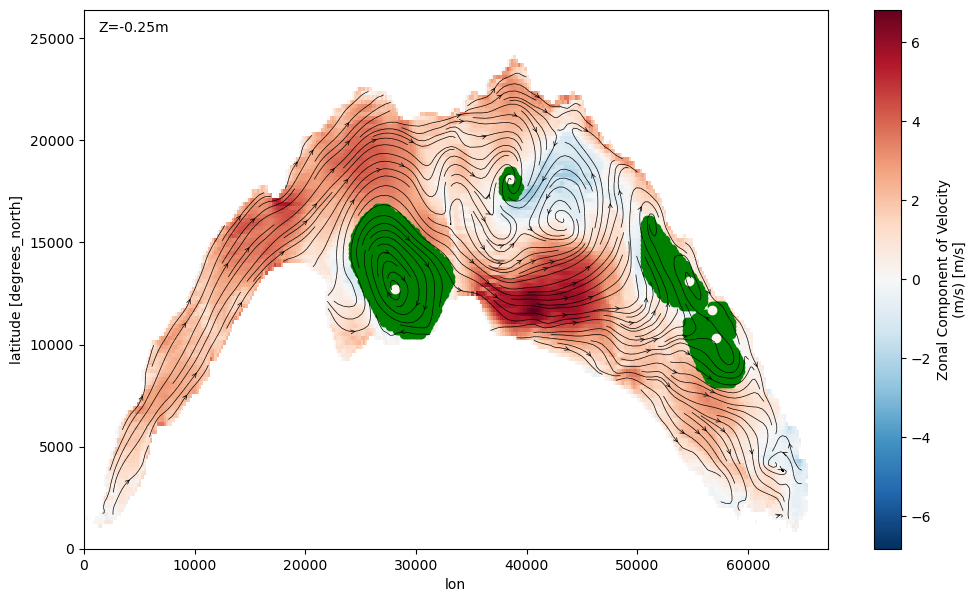

In [15]:
%matplotlib inline
fig = plot_map_eddies(data_aligned.isel(time=t_index), test_eddies, '', stream_density = 4)